In [1]:
%matplotlib inline

import Regression_Class as Reg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
plt.style.use('seaborn')

In [2]:
df = pd.read_csv(
    "C:\\Users\\wince\\Google Drive\\DATA SCIENCE\\LEZIONI\\ML\\Polignano\\01.REGRESSION\\DataEx_LinRegression\\heart.arff.csv",
    delimiter=',')

In [3]:
df.shape

(303, 14)

In [4]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [5]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


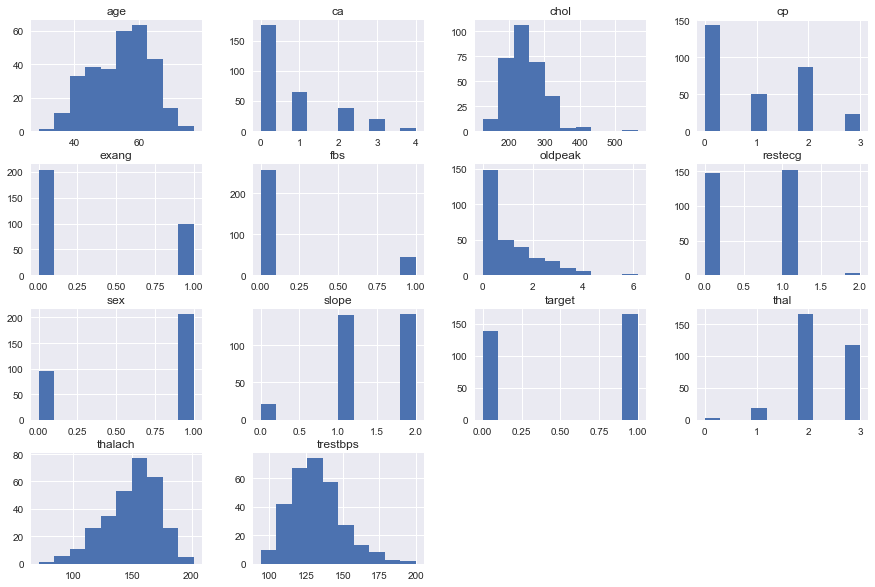

In [6]:
df.hist(bins=10, figsize=(15, 10));

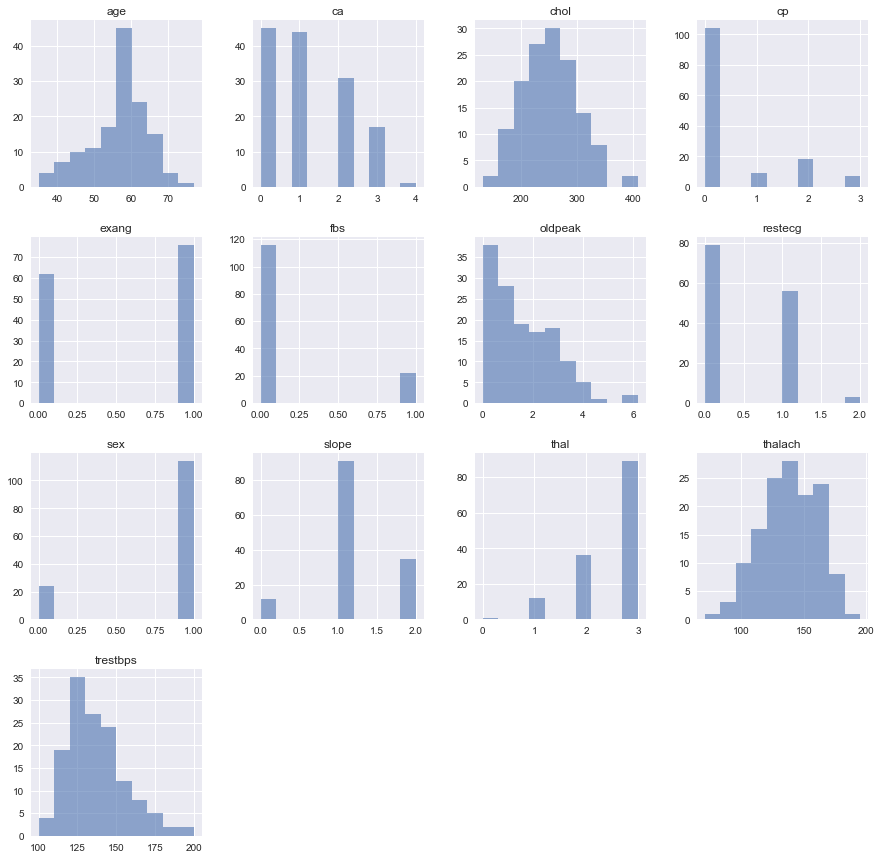

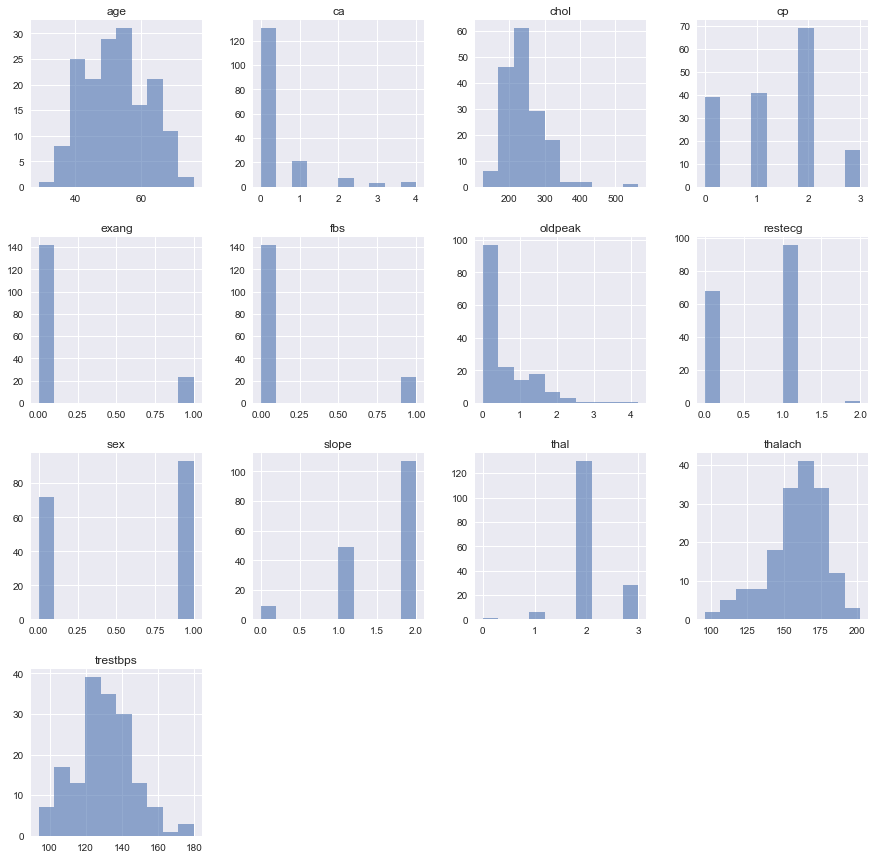

In [7]:
df.groupby('target').hist(figsize=(15, 15), alpha=.6);

In [8]:
df.groupby(['sex']).target.size().to_frame()

,target
sex,
0,96
1,207


In [9]:
df.groupby(['target']).ca.size().to_frame()

,ca
target,
0,138
1,165


In [10]:
num_columns = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
ord_columns = []
#ord_columns = ['cp', 'restecg', 'slope', 'thal', 'ca']
cat_columns = [col for col in df.columns if col not in (num_columns + ord_columns)]
cat_columns

['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'target']

In [11]:
df[cat_columns] = df[cat_columns].astype('category')

In [12]:
df[num_columns] = df[num_columns].transform(lambda x: (x-x.mean())/x.std())

In [13]:
#df[num_columns] = df[num_columns].transform(lambda x: np.log(x))

In [14]:
#df[ord_columns] = df[ord_columns].transform(lambda x: (x-x.min())/(x.max()-x.min()))

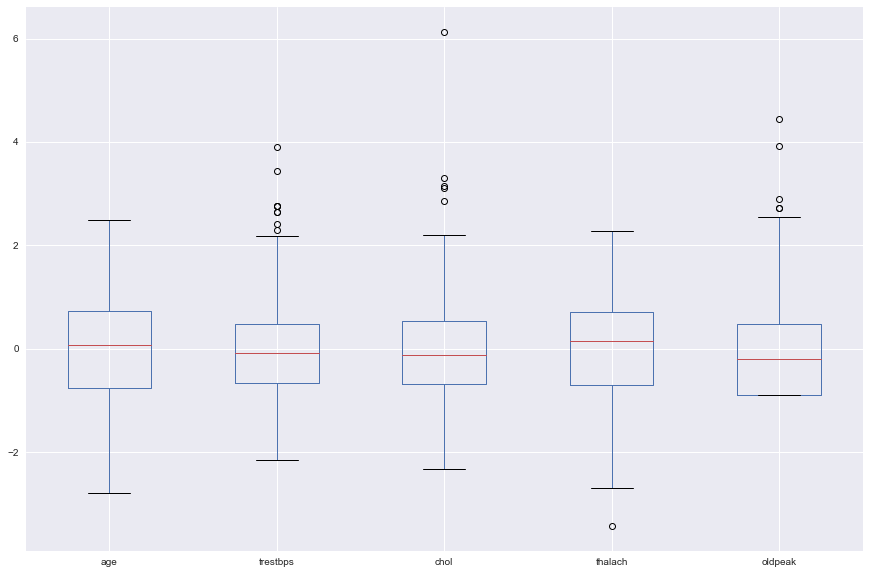

In [15]:
df.plot.box(figsize=(15, 10));

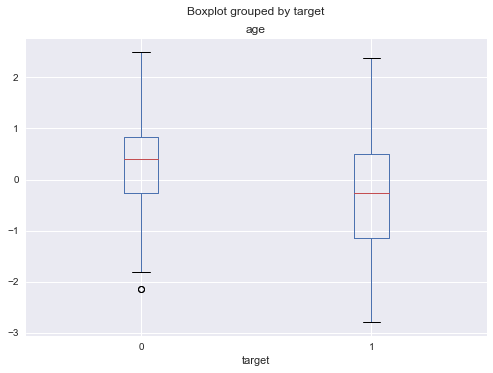

In [16]:
df.boxplot(column='age', by='target');

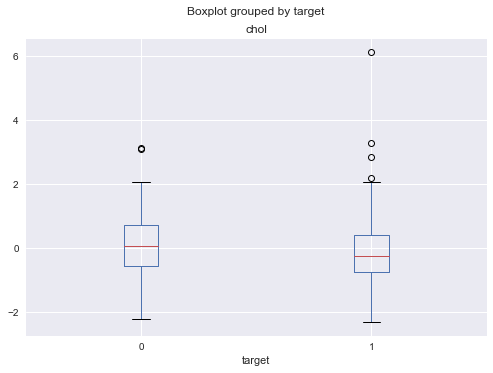

In [17]:
df.boxplot(column='chol', by='target');

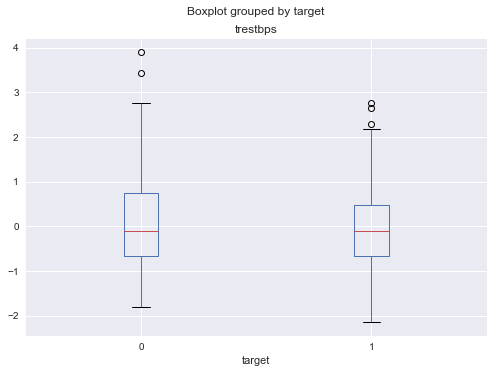

In [18]:
df.boxplot(column='trestbps', by='target');

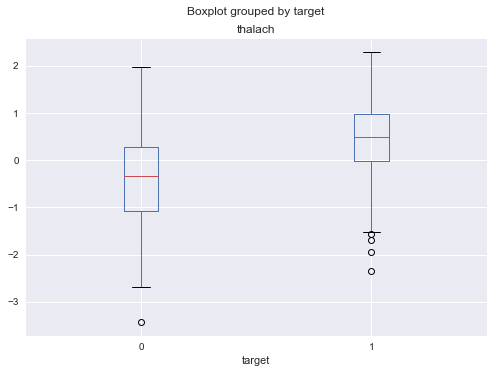

In [19]:
df.boxplot(column='thalach', by='target');

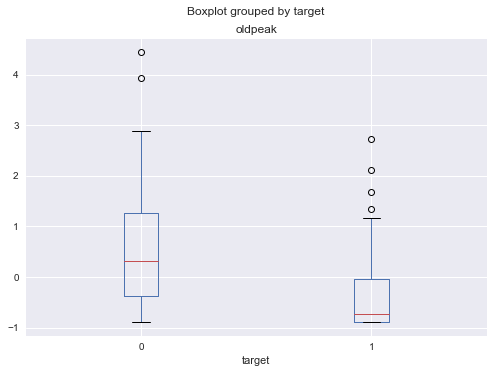

In [20]:
df.boxplot(column='oldpeak', by='target');

In [21]:
df1 = pd.get_dummies(df, sparse=False, drop_first=True)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,0.950624,1,3,0.762694,-0.255910,1,0,0.015417,0,1.085542,0,0,1,1
1,-1.912150,1,2,-0.092585,0.072080,0,1,1.630774,0,2.119067,0,0,2,1
2,-1.471723,0,1,-0.092585,-0.815424,0,0,0.975900,0,0.310399,2,0,2,1
3,0.179877,1,1,-0.662770,-0.198030,0,1,1.237849,0,-0.206364,2,0,2,1
4,0.289984,0,0,-0.662770,2.078611,0,1,0.582975,1,-0.378618,2,0,2,1


In [22]:
df_mix = df1.sample(frac=1, random_state=3479).reset_index(drop=True)
df_mix.head()

,age,trestbps,chol,thalach,oldpeak,sex_1,cp_1,cp_2,cp_3,fbs_1,...,slope_1,slope_2,ca_1,ca_2,ca_3,ca_4,thal_1,thal_2,thal_3,target_1
0,1.060731,-0.092585,1.094639,-1.207015,0.827161,0,0,0,0,0,...,1,0,0,1,0,0,0,1,0,1
1,0.289984,-1.232956,1.712033,-0.290191,1.688432,1,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0
2,-0.370656,-0.092585,0.187842,-0.028241,-0.464745,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,1
3,-2.242470,-0.776808,-0.699662,1.849065,-0.292491,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,1
4,0.620304,0.762694,0.689474,-0.333849,1.516178,1,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0


In [23]:
df_mix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        303 non-null    float64
 1   trestbps   303 non-null    float64
 2   chol       303 non-null    float64
 3   thalach    303 non-null    float64
 4   oldpeak    303 non-null    float64
 5   sex_1      303 non-null    uint8  
 6   cp_1       303 non-null    uint8  
 7   cp_2       303 non-null    uint8  
 8   cp_3       303 non-null    uint8  
 9   fbs_1      303 non-null    uint8  
 10  restecg_1  303 non-null    uint8  
 11  restecg_2  303 non-null    uint8  
 12  exang_1    303 non-null    uint8  
 13  slope_1    303 non-null    uint8  
 14  slope_2    303 non-null    uint8  
 15  ca_1       303 non-null    uint8  
 16  ca_2       303 non-null    uint8  
 17  ca_3       303 non-null    uint8  
 18  ca_4       303 non-null    uint8  
 19  thal_1     303 non-null    uint8  
 20  thal_2    

In [24]:
log_reg = Reg.Regressor(target='target_1', l_rate=.3, reg_rate=1, beta=1)

In [25]:
X_train, y_train, X_test, y_test = log_reg.split(df_mix, cutoff=.8)

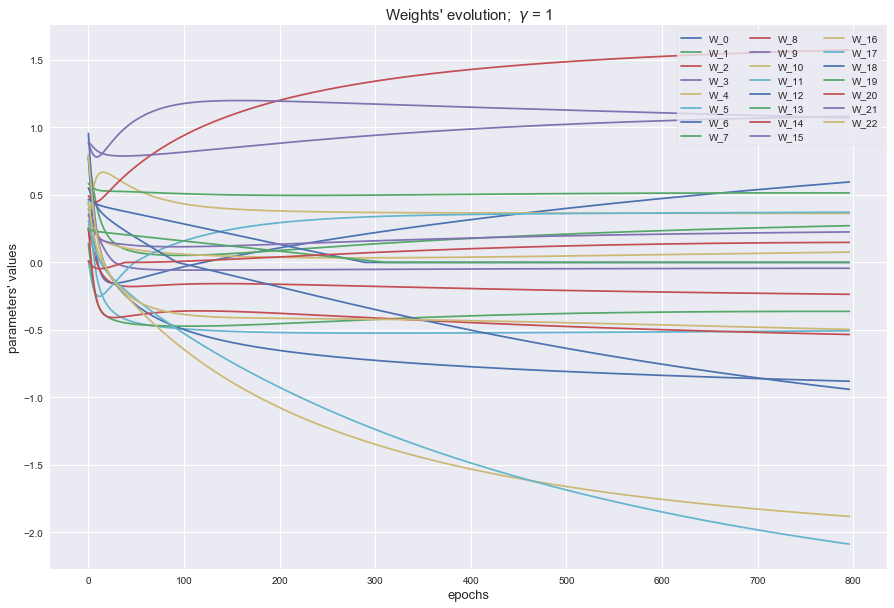

In [26]:
log_reg.fit(X_train, y_train, graph=True, reset=True).predict(X_test);

In [27]:
features = np.insert(df_mix.columns.to_numpy()[:-1], 0, 'bias')
weights = pd.DataFrame({'features': features, 'weights': log_reg.weights.reshape(log_reg.weights.shape[-1])})
weights

,features,weights
0,bias,0.595549
1,age,0.271843
2,trestbps,-0.236284
3,chol,-0.043365
4,thalach,0.362174
5,oldpeak,-0.506905
6,sex_1,-0.879917
7,cp_1,0.514865
8,cp_2,1.573853
9,cp_3,1.081179


In [28]:
log_reg.metrics(y_test)

Accuracy: 0.8524590163934426
Precision: 0.8684210503462604
Recall: 0.8918918894813732
F1 score: 0.879999947662225

Confusion Matrix:
 [[33  5]
 [19  4]]


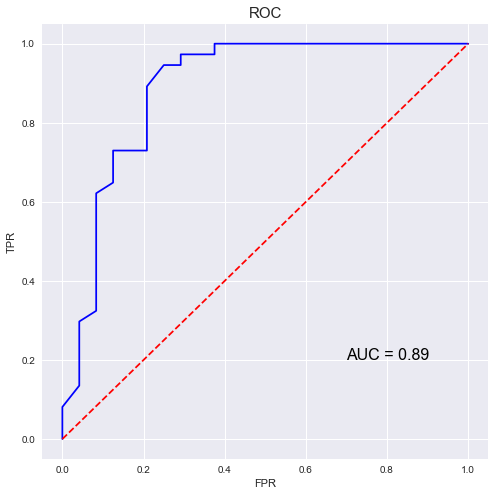

In [29]:
log_reg.ROC(y_test)

In [30]:
log_reg.cross_val(df_mix, folds=100)

Accuracy: 0.87
Precision: 0.8554913289852651
Recall: 0.9135802463496419
F1 score: 0.8835820890247271

Confusion Matrix:
 [[148  25]
 [113  14]]


In [31]:
X_mix, y_mix, _, _ = log_reg.split(df_mix, cutoff=1.)

In [32]:
log_reg.predict(X_mix).metrics(y_mix)

Accuracy: 0.8679867986798679
Precision: 0.8698224846924127
Recall: 0.890909090369146
F1 score: 0.8802394704381684

Confusion Matrix:
 [[147  22]
 [116  18]]


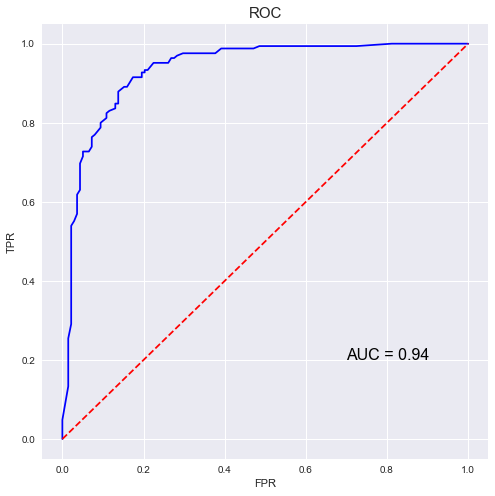

In [33]:
log_reg.ROC(y_mix)